# Partie 3 : Analyse avec un Modèle Pré-Entrainé

###

## OBJECTIF: Classifier les images à partir d'un modèle pré entrainé

**Méthode 1** : A partir de toutes les couches de convolution, Extraire les caractéristiques(ou extraction des features) pertinent du modèle pré-entrainé pour Entrainé le nouveau modèle.

**NB**: Lorsqu'on extrait les caractéristiques, en entrainant le modèle on doit se rassurer que la couche de prédiction du modèle pré-entrainer est bien géler ou supprimer.on recupere uniquement les couches extraction des caractéristiques.

**Méthode 2** : le fineturning: Je récupere le modèle pré-entrainer j'applique exactement le même modèle, par contre on revoir les pondérations afin qu'ils ne soient pas entrainer de nouveau.Autrement dit on gele plusieurs couche et entrainer uniquement quelque paramètre pour avoir de très bonne performance sur notre base de donnée

###

# SOMMAIRE 

**1. Introduction**<br />
&emsp;1.1 Télechargement et option<br />
&emsp;1.2 Importer les différentes librairies necessaire<br />
&emsp;1.3 Charger la base de donnée<br />
**2. Etude de faisabilité**<br />
&emsp;2.1 Création du modèle pré-entraîné<br />
&emsp;2.2 Extraction des features des images<br />
&emsp;2.3 Réduction dimension et analyse<br />
&emsp;2.4 Réduction de dimension T-SNE et affichage des images selon vraies classes<br />
&emsp;2.5 Analyse par classes<br />
**3. Classification supervisée**<br />
&emsp;3.1 Création du modèle de classification<br />
&emsp;3.2 Approche préparation initiale des images<br />
**4. Approche Data generator**<br />
&emsp;4.1 Modèle<br />
&emsp;4.2 Performance du modèle<br />
&emsp;4.3 Prédiction du modèle initiale<br />
**5. Approche nouvelle par Dataset sans data augmentation**<br />
&emsp;5.1 Extraction Rapide des Caractéristiques sans Augmentation des Données<br />
&emsp;5.2 Performance du modèle<br />
**6. Approche nouvelle par Dataset avec data augmentation**<br />
&emsp;6.1 Modèle<br />
&emsp;6.2 Performance du modèle<br />
**7. Test d'API de collecte de donnée**<br />

#####

### 1.1 Télechargement et option

In [87]:
pip install plot-keras-history

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1.2 Importer les différentes librairies necessaire

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from matplotlib.image import imread

# os.environ["TF_KERAS"]='1'
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

### 1.3 Charger la base de donnée totale

In [20]:
df_path = r"C:\Users\521169\Documents\Openclassrooms\Projet 6\Jeu de donnée\Dataset+projet+prétraitement+textes+images (1)\Flipkart\flipkart_com-ecommerce_sample_1050.csv"
data = pd.read_csv(df_path)
data.head(3)   

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


- **Création des labels des photos à partir de ses catégories**

In [21]:
from sklearn.preprocessing import LabelEncoder

data = data.copy()
# Déterminons toutes les catégories 
categories = data["product_category_tree"].apply(lambda x: x.split('>>')[0].strip('["'))

# Créer l'instance de LabelEncoder
le = LabelEncoder()
df_label = pd.DataFrame()
df_label["pictures"] = data["image"]
df_label["CATEGORIES"] = categories
df_label["picture_label"] = df_label["pictures"].str.replace(r'\.(jpg|png)$','',regex=True)
df_label["label"] = le.fit_transform(df_label["CATEGORIES"])
df_label.head()

,pictures,CATEGORIES,picture_label,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,7b72c92c2f6c40268628ec5f14c6d590,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,64d5d4a258243731dc7bbb1eef49ad74,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7,4


In [22]:
df_label.groupby("label").count()['CATEGORIES']

label
0    150
1    150
2    150
3    150
4    150
5    150
6    150
Name: CATEGORIES, dtype: int64

In [23]:
df_label['CATEGORIES'].value_counts()

CATEGORIES
Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: count, dtype: int64

- **Dossier image**

In [25]:
# path throught image
img_path = r"C:\Users\521169\Documents\Openclassrooms\Projet 6\Jeu de donnée\Dataset+projet+prétraitement+textes+images (1)\Flipkart\Images"

# Listing all files in the directory
file_names = os.listdir(img_path)
# Creation d'un dataframe avec le nom des fichiers
file_names_df = pd.DataFrame(file_names, columns=["Folder_Image"])
file_names_df.head()

,Folder_Image
0,009099b1f6e1e8f893ec29a7023153c4.jpg
1,0096e89cc25a8b96fb9808716406fe94.jpg
2,00cbbc837d340fa163d11e169fbdb952 - Copie.jpg
3,00cbbc837d340fa163d11e169fbdb952.jpg
4,00d84a518e0550612fcfcba3b02b6255 - Copie.jpg


In [26]:
list_1 = file_names_df["Folder_Image"].to_list()
list_2 = df_label["pictures"].to_list()
compare1 = set(list_1) - set(list_2)
compare1

{'00cbbc837d340fa163d11e169fbdb952 - Copie.jpg',
 '00d84a518e0550612fcfcba3b02b6255 - Copie.jpg',
 '00e966a5049a262cfc72e6bbf68b80e7 - Copie.jpg',
 '00ed03657cedbe4663eff2d7fa702a33 - Copie.jpg',
 '0a3b5fdf77a361c2d7d9b29c259b8c4e - Copie.jpg',
 '0a8a1e9c6659361c0c2b247f8a6471d0 - Copie.jpg',
 '0abfcbe0e17dd50c4cf5fb1d6037d514 - Copie.jpg',
 '0ae859a69c7608d8197c3ba8c37bc6ec - Copie.jpg',
 '0b793c1727ef52285a25dedf8b86626b - Copie.jpg',
 '0b852704f2002f8865a68818ad4951da - Copie.jpg',
 '0b8c4bc35aee94af356cb1fd2dfa0219 - Copie.jpg',
 '0bb0f7b7a3075f4b9459121abe2185fa - Copie.jpg',
 '0bff0eda7a6677dc1acb0477a1f7a121 - Copie.jpg',
 '0c4718ae90f2889b7021a99ee1cc106c - Copie.jpg',
 '0c70a580d96e50966130e2885d8c3505 - Copie.jpg',
 '0ca8e323551dd7107ef57ef7c3e77aee - Copie.jpg',
 '0d02f4703fde00645704e15bba23e77d - Copie.jpg'}

In [27]:
compare2 = set(list_2) - set(list_1)
compare2

set()

In [28]:
# on suppression des images contenant des copies
file_names_df = file_names_df[~file_names_df["Folder_Image"].isin(compare1)]
folder_picture = file_names_df[["Folder_Image"]]
folder_picture.head()

,Folder_Image
0,009099b1f6e1e8f893ec29a7023153c4.jpg
1,0096e89cc25a8b96fb9808716406fe94.jpg
3,00cbbc837d340fa163d11e169fbdb952.jpg
5,00d84a518e0550612fcfcba3b02b6255.jpg
7,00e966a5049a262cfc72e6bbf68b80e7.jpg


In [29]:
# Créer un dictionnaire de correspondance entre image1 et catégorie1
mapping = dict(zip(df_label["pictures"], df_label["CATEGORIES"]))

# Remplir la colonne catégorie2 en fonction de image2
folder_picture["CATEGORIES2"] = folder_picture["Folder_Image"].map(mapping)
folder_picture.head()

,Folder_Image,CATEGORIES2
0,009099b1f6e1e8f893ec29a7023153c4.jpg,Watches
1,0096e89cc25a8b96fb9808716406fe94.jpg,Kitchen & Dining
3,00cbbc837d340fa163d11e169fbdb952.jpg,Home Furnishing
5,00d84a518e0550612fcfcba3b02b6255.jpg,Beauty and Personal Care
7,00e966a5049a262cfc72e6bbf68b80e7.jpg,Computers


In [30]:
folder_picture["label2"] = le.fit_transform(folder_picture["CATEGORIES2"])
folder_picture.head()

,Folder_Image,CATEGORIES2,label2
0,009099b1f6e1e8f893ec29a7023153c4.jpg,Watches,6
1,0096e89cc25a8b96fb9808716406fe94.jpg,Kitchen & Dining,5
3,00cbbc837d340fa163d11e169fbdb952.jpg,Home Furnishing,4
5,00d84a518e0550612fcfcba3b02b6255.jpg,Beauty and Personal Care,1
7,00e966a5049a262cfc72e6bbf68b80e7.jpg,Computers,2


In [31]:
folder_picture.shape

(1050, 3)

In [32]:
listImage = folder_picture["Folder_Image"].to_list()

In [33]:
df_final = folder_picture[["Folder_Image","CATEGORIES2"]]
df_final.head()

,Folder_Image,CATEGORIES2
0,009099b1f6e1e8f893ec29a7023153c4.jpg,Watches
1,0096e89cc25a8b96fb9808716406fe94.jpg,Kitchen & Dining
3,00cbbc837d340fa163d11e169fbdb952.jpg,Home Furnishing
5,00d84a518e0550612fcfcba3b02b6255.jpg,Beauty and Personal Care
7,00e966a5049a262cfc72e6bbf68b80e7.jpg,Computers


In [34]:
liste = df_final["CATEGORIES2"].to_list()
list_category= list(set(liste))
list_category

['Kitchen & Dining ',
 'Beauty and Personal Care ',
 'Watches ',
 'Baby Care ',
 'Computers ',
 'Home Furnishing ',
 'Home Decor & Festive Needs ']

- **Extraction d'image**

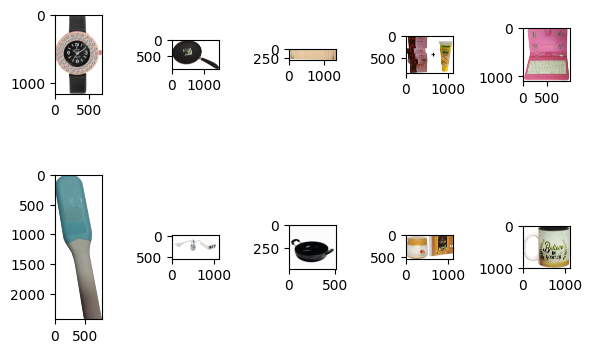

In [35]:
from PIL import Image

# Récupération de tous les fichiers dans le dossier
dataimage = os.listdir(img_path)

# Filtrage pour garder seulement les fichiers images
data_images = [f for f in listImage if f.endswith(('.png', '.jpg', '.jpeg'))]

# Création d'une figure pour afficher les images
plt.figure(figsize=(6, 4)) 

# Itérer sur les 4 premières images
for index, image_name in enumerate(data_images[:10]): 
    # Chemin complet vers l'image
    chemin_image = os.path.join(img_path, image_name)
    # Chargement de l'image
    image = Image.open(chemin_image)
    
    # Ajout de l'image dans une sous-grille
    plt.subplot(2, 5, index + 1)  
    plt.imshow(image)

plt.tight_layout()  
plt.show()

#####

#

# 2. Etude de faisabilité

## 2.1- Création du modèle pré-entraîné

### VGG16: modèle de convolution profond avec 16 couches

In [67]:
# modèle pré-entrainer VGG16
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


### 2.2 - Extraction des features des images

In [68]:
images_features = []
i=0 
for index, image_file in enumerate(listImage):
    if i%100 == 0 : print(i)
    i +=1
    chemin_image = os.path.join(img_path, image_file)
    image = load_img(chemin_image, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0


C:\Users\521169\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_202']. Received: the structure of inputs=*
  warnings.warn(


100
200
300


C:\Users\521169\AppData\Roaming\Python\Python311\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


400
500
600
700
800
900
1000


(1050, 4096)

### 2.3- Réduction dimension et analyse

####  - Réduction de dimension PCA

In [69]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


### 2.4- Réduction de dimension T-SNE et affichage des images selon vraies classes

In [70]:
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

C:\Users\521169\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


temps de T-SNE :            23.72 secondes


- **Graphe T_SNE**

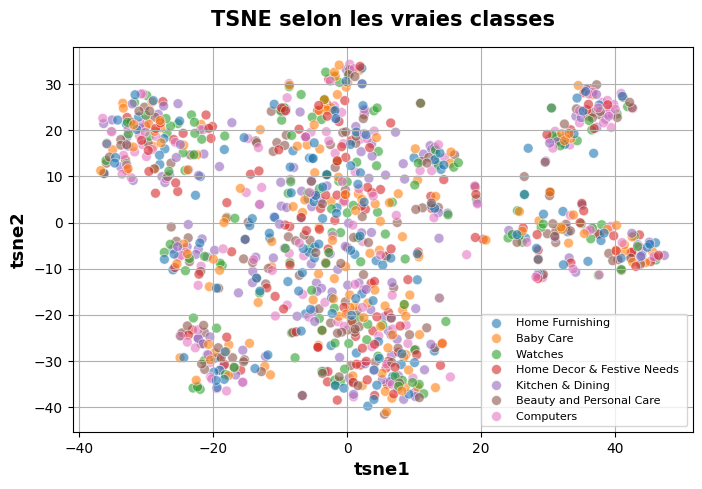

In [71]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
# Analyser la catégorie dans un format simplifié 
data['simplified_category'] = data['product_category_tree'].apply(lambda x: x.split('>>')[0].strip('["'))
df_tsne["class"] = data["simplified_category"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 15, pad = 15, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 13, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 13, fontweight = 'bold')
plt.grid(True)
plt.legend(prop={'size': 8}) 

plt.show()

In [72]:
from sklearn import cluster, metrics
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

C:\Users\521169\AppData\Local\Temp\ipykernel_29412\3848366375.py:4: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


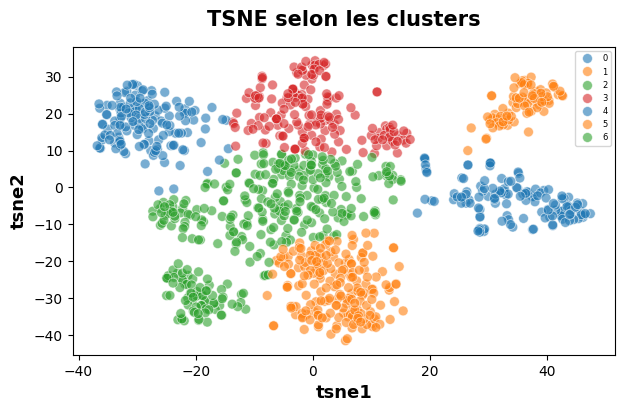

ARI :  0.45499248305848305


In [74]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(7,4))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 15, pad = 15, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 13, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 13, fontweight = 'bold')
plt.legend(prop={'size': 6}) 

plt.show()

labels = folder_picture["label2"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

## 2.5 - Analyse par classes

In [154]:
# Matrice de confusion
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  0   1  24   2   3 110  10]
 [  1   1  13   8 117   4   6]
 [  1   0  34 113   1   1   0]
 [  8   0  77   5   1   3  56]
 [  0   0   5   0   0  76  69]
 [  0  79  30  32   9   0   0]
 [135   0   2  13   0   0   0]]


In [155]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [156]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [6 5 3 2 1 0 4]
[[110   3   2  24  10   1   0]
 [  4 117   8  13   6   1   1]
 [  1   1 113  34   0   0   1]
 [  3   1   5  77  56   0   8]
 [ 76   0   0   5  69   0   0]
 [  0   9  32  30   0  79   0]
 [  0   0  13   2   0   0 135]]

              precision    recall  f1-score   support

           0       0.57      0.73      0.64       150
           1       0.89      0.78      0.83       150
           2       0.65      0.75      0.70       150
           3       0.42      0.51      0.46       150
           4       0.49      0.46      0.47       150
           5       0.98      0.53      0.68       150
           6       0.93      0.90      0.92       150

    accuracy                           0.67      1050
   macro avg       0.70      0.67      0.67      1050
weighted avg       0.70      0.67      0.67      1050



<Axes: >

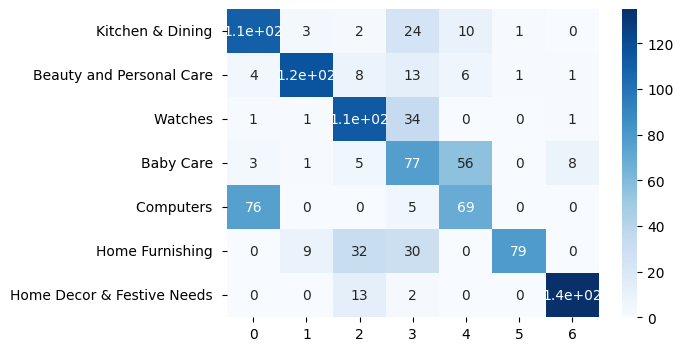

In [161]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_category],
                    columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
                  
sns.heatmap(df_cm, annot=True, cmap="Blues")

 **Daprès ce tableau de contingence, on constate que les résultats sont meilleurs par rapport au modèle basique.**<br />
 **Ici chaque cluster est presque associé à une catégorie bien définie.**<br />

#

# 3- Classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle

## 3.1 Création du modèle de classification

In [80]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

## 3.2   Approche préparation initiale des images

In [92]:
def image_prep_fct(df_final, img_path):
    prepared_images = []
    for image_name in df_final['Folder_Image']:
        # Construire le chemin complet de l'image
        image_path = os.path.join(img_path, image_name)
        
        # Charger, prétraiter et ajouter l'image à la liste
        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)  # Prétraitement pour les modèles de Keras
        prepared_images.append(img)
    
    # Convertir la liste en array numpy
    prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(df_final, img_path)
print(f"Shape des images d'entraînement : {images_np.shape}")

data_test = folder_picture.sample(210)
images_np_test = image_prep_fct(data_test, img_path)
print(f"Shape des images de test : {images_np_test.shape}")

C:\Users\521169\AppData\Roaming\Python\Python311\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Shape des images d'entraînement : (1050, 224, 224, 3)
Shape des images de test : (210, 224, 224, 3)


In [93]:
data_test.head()

,Folder_Image,CATEGORIES2,label2
641,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
740,a9b35b94610a3d7f4fa91f19693c5248.jpg,Home Decor & Festive Needs,3
861,cb096f17218f0e4ccd7424963e2cd0f8.jpg,Beauty and Personal Care,1
748,ac209ee3c602efed4ff093854a4ade06.jpg,Watches,6
370,59af3731b809a25f2bf99e99f645d8dd.jpg,Kitchen & Dining,5


In [94]:
X = images_np
y = to_categorical(folder_picture["label2"])

X_test = images_np_test
y_test = to_categorical(data_test["label2"])

y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [95]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(787, 224, 224, 3)

In [96]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = r"C:/Users/521169/Documents/Openclassrooms/Projet 6/Jeu de donnée/Dataset+projet+prétraitement+textes+images (1)/Flipkart/Images_model.keras"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [97]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=15, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3494 - loss: 8.1010 
Epoch 1: val_loss improved from inf to 1.33999, saving model to C:/Users/521169/Documents/Openclassrooms/Projet 6/Jeu de donnée/Dataset+projet+prétraitement+textes+images (1)/Flipkart/Images_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 205s 15s/step - accuracy: 0.3577 - loss: 7.9256 - val_accuracy: 0.7871 - val_loss: 1.3400
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6885 - loss: 2.2622 
Epoch 2: val_loss improved from 1.33999 to 1.16210, saving model to C:/Users/521169/Documents/Openclassrooms/Projet 6/Jeu de donnée/Dataset+projet+prétraitement+textes+images (1)/Flipkart/Images_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 188s 15s/step - accuracy: 0.6897 - loss: 2.2450 - val_accuracy: 0.8099 - val_loss: 1.1621
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7881 - loss: 0.9727 
Epoch 3: val_loss improved from 1.16210 to 0.97257, saving model to C:/Users/521169/Documents/Openc

In [98]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.9997 - loss: 0.0157
Training Accuracy: 0.9987

9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.8400 - loss: 1.0242
Validation Accuracy:  0.8517


In [99]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Training Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Training Accuracy :  0.8517
Test Accuracy       :  0.9524


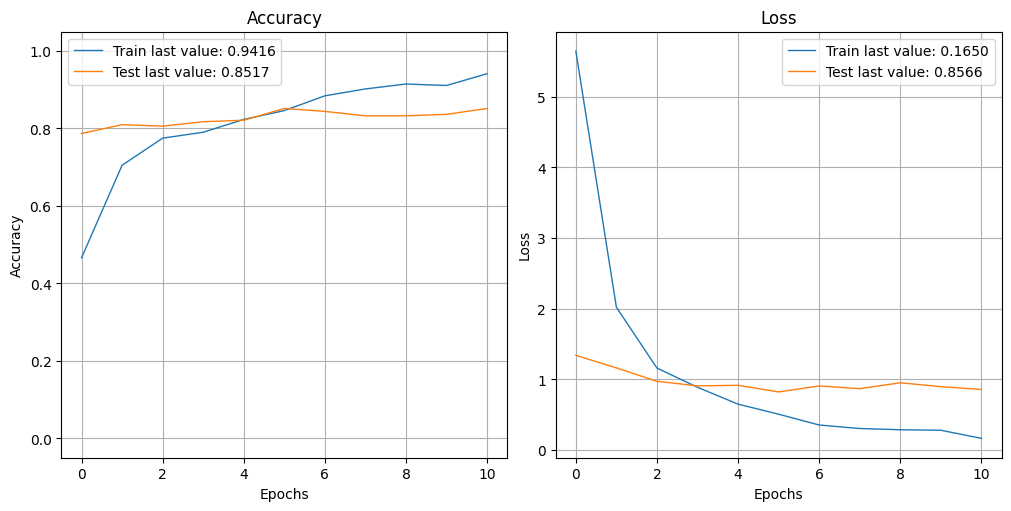

In [100]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [101]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step
[3 3 1 4 3 1 5 0 3 0 0 4 6 5 0 6 5 0 2 6 2 2 1 0 4 5 4 6 2 2 0 2 1 3 2 0 4
 0 0 1 6 6 1 1 4 4 0 6 2 3 1 2 3 6 1 4 6 1 4 0 1 6 5 1 0 6 5 3 6 0 3 4 0 0
 4 2 4 4 6 3 1 4 5 5 1 2 1 0 3 5 5 2 3 1 6 3 6 5 5 1 5 4 2 4 0 0 0 6 4 6 5
 0 4 5 5 6 1 4 2 1 4 0 3 3 2 3 4 2 0 3 3 0 5 1 3 3 1 5 0 1 0 3 5 2 0 1 5 6
 1 2 6 0 2 1 1 0 3 3 4 3 1 2 5 5 3 5 1 2 4 3 1 2 5 5 2 2 0 0 3 6 0 4 4 1 4
 4 1 3 6 3 6 5 2 5 0 2 2 1 6 2 0 6 4 3 3 5 3 4 1 4 0 5 5 5 2 5 6 3 6 4 6 2
 5 4 1 4 6 6 4 1 3 6 5 6 3 6 3 2 3 2 5 6 0 2 4 5 0 4 3 0 2 4 4 2 2 5 2 6 1
 6 6 2 1]

[3 3 1 4 5 1 1 0 3 0 0 4 6 5 0 6 5 0 2 1 2 2 1 0 4 5 1 1 2 2 0 2 3 3 2 5 4
 0 0 1 6 6 1 2 4 4 0 6 2 3 1 2 5 6 1 4 6 1 4 0 0 6 5 1 0 6 5 3 5 0 1 4 0 0
 0 2 4 0 6 3 1 0 5 1 1 2 1 0 3 5 5 1 1 6 6 3 6 5 5 1 5 4 2 4 0 3 0 6 4 6 5
 0 4 5 5 6 1 4 2 1 4 0 3 5 2 3 1 2 0 3 3 0 5 1 1 3 1 5 0 1 1 5 5 2 3 1 5 1
 1 2 6 0 5 1 1 5 5 3 0 0 1 2 5 5 3 5 1 2 4 3 1 2 5 5 2 2 4 4 3 6 0 4 4 1 4
 4 1 3 6 3 6 5 2 2 0 2 2 1 6 2 0 6 4 3 0 3 3 4 1 4 0

In [102]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[30  1  0  3  2  2  0]
 [ 1 33  1  1  0  0  1]
 [ 0  1 36  0  0  1  0]
 [ 2  3  0 28  0  5  0]
 [ 5  2  0  0 31  0  0]
 [ 0  2  1  1  0 33  0]
 [ 0  3  0  0  0  1 33]]


In [103]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[30  1  0  3  2  2  0]
 [ 1 33  1  1  0  0  1]
 [ 0  1 36  0  0  1  0]
 [ 2  3  0 28  0  5  0]
 [ 5  2  0  0 31  0  0]
 [ 0  2  1  1  0 33  0]
 [ 0  3  0  0  0  1 33]]

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        38
           1       0.73      0.89      0.80        37
           2       0.95      0.95      0.95        38
           3       0.85      0.74      0.79        38
           4       0.94      0.82      0.87        38
           5       0.79      0.89      0.84        37
           6       0.97      0.89      0.93        37

    accuracy                           0.85       263
   macro avg       0.86      0.85      0.85       263
weighted avg       0.86      0.85      0.85       263



## **Tableau de contingence**

<Axes: >

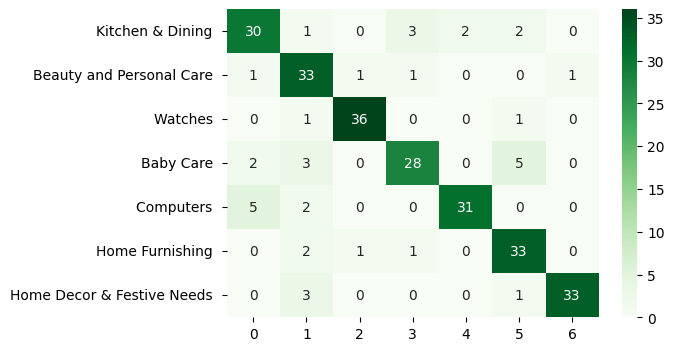

In [105]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_category],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Greens")

#

# 4. Approche Data generator 

## Prétraitement des données pour la génération d'images

1. Lire les fichiers d'image
La première étape consiste à lire les fichiers d'image. Cela permet de charger les images brutes dans votre programme pour les étapes suivantes de prétraitement.

2. Décoder le contenu JPEG en grilles de pixels RGB
Une fois que les images sont lues, nous devons les décoder à partir de leur format JPEG compressé en grilles de pixels RGB (Rouge, Vert, Bleu). Cela transforme l'image en une matrice de valeurs numériques représentant les couleurs.

3. Convertir ces grilles en tableaux de nombres à virgule flottante
Les réseaux de neurones travaillent mieux avec des nombres. Nous devons donc convertir les grilles de pixels en tableaux de nombres à virgule flottante pour pouvoir les utiliser dans nos modèles de deep learning.

4. Rescaler les valeurs des pixels entre 0 et 255 à l'intervalle 0,1
Les réseaux de neurones préfèrent traiter des valeurs d'entrée petites et normalisées. Nous devons donc rescaler les valeurs des pixels de leur intervalle original [0, 255] à l'intervalle [0, 1].

In [107]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [108]:
train_datagen = ImageDataGenerator(rescale=1./255,  # Ré-échelle les valeurs des pixels entre 0 et 255 à l'intervalle 0,1
                                   validation_split=0.2)  # 20% des données pour la validation
df_final.head(10)

,Folder_Image,CATEGORIES2
0,009099b1f6e1e8f893ec29a7023153c4.jpg,Watches
1,0096e89cc25a8b96fb9808716406fe94.jpg,Kitchen & Dining
3,00cbbc837d340fa163d11e169fbdb952.jpg,Home Furnishing
5,00d84a518e0550612fcfcba3b02b6255.jpg,Beauty and Personal Care
7,00e966a5049a262cfc72e6bbf68b80e7.jpg,Computers
9,00ed03657cedbe4663eff2d7fa702a33.jpg,Computers
10,01089dc3618a0ab7304d784ef400b83d.jpg,Computers
11,0131e5d87b72877702d536299cf83b75.jpg,Kitchen & Dining
12,020d2daba55a723128e4e07c0b0393a9.jpg,Beauty and Personal Care
13,02127f52e96fb72c66bf081d25104ef8.jpg,Kitchen & Dining


- **Donnée d'entrainement**

In [40]:
# Générateur pour les données d'entraînement
train_generator = train_datagen.flow_from_dataframe(
    df_final,
    img_path,
    x_col='Folder_Image',
    y_col='CATEGORIES2',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Utiliser les données d'entrainnement
)

Found 840 validated image filenames belonging to 7 classes.


- **Donnée de validation**

In [41]:
# Générateur pour les données de validation
validation_generator = train_datagen.flow_from_dataframe(
    df_final,
    img_path,
    x_col='Folder_Image',
    y_col='CATEGORIES2',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Utiliser les données de validation
)

Found 210 validated image filenames belonging to 7 classes.


- **Creation du modèle**

Taille du lot de données : (32, 224, 224, 3)
Taille du lot d'étiquettes : (32, 7)


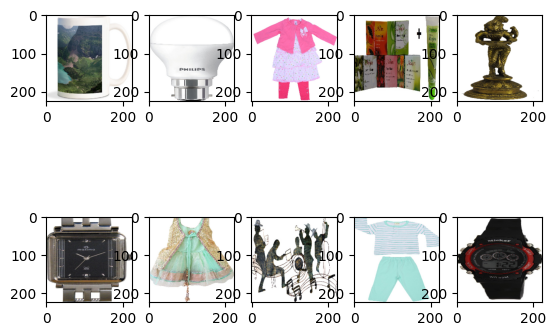

In [42]:
# Affichage de quelques images pour vérifier le prétraitement
for data_batch, labels_batch in train_generator:
    print("Taille du lot de données :", data_batch.shape)  # Affiche la forme du lot de données
    print("Taille du lot d'étiquettes :", labels_batch.shape)  # Affiche la forme du lot d'étiquettes
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(data_batch[i])  # Affiche l'image prétraitée
    plt.show()
    break  # Affiche un seul lot d'images

## **4.1 Modèle**

In [47]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models


model = models.Sequential()

# Ajouter les couches une par une

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  # Couche de convolution : 32 filtres de 3x3, détecte des motifs simples dans l'image, ReLU pour rendre le modèle non-linéaire, forme d'entrée (150x150x3).

model.add(layers.MaxPooling2D((2, 2)))  # Couche de max pooling : réduit les dimensions de l'image en prenant le maximum de chaque carré de 2x2 pixels.

model.add(layers.Conv2D(64, (3, 3), activation='relu'))  # Deuxième couche de convolution : 64 filtres de 3x3, détecte des motifs plus complexes, ReLU pour l'activation.

model.add(layers.MaxPooling2D((2, 2)))  # Deuxième couche de max pooling : réduit encore les dimensions de l'image.

model.add(layers.Conv2D(128, (3, 3), activation='relu'))  # Troisième couche de convolution : 128 filtres de 3x3, détecte des motifs encore plus complexes, ReLU pour l'activation.

model.add(layers.MaxPooling2D((2, 2)))  # Troisième couche de max pooling : réduit encore les dimensions de l'image.

model.add(layers.Flatten())  # Couche Flatten : transforme les données 2D en un vecteur 1D pour la couche dense suivante.

model.add(layers.Dense(512, activation='relu'))  # Couche dense (fully connected) : 512 neurones, chaque neurone est connecté à tous les neurones de la couche précédente, ReLU pour l'activation.

model.add(layers.Dense(7, activation='softmax'))  # Couche de sortie : 1 neurone, activation softmax pour produire une probabilité entre 0 et 1, utilisée pour la classification multi class (habit,chaussure,chaussette,...).


In [48]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,399,687 (169.37 MB)

 Trainable params: 44,399,687 (169.37 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
from keras import optimizers

optimi = optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=optimi,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
# Entraînement du modèle et sauvegarde de l'historique d'entraînement dans 'history'
history = model.fit(
    train_generator,  # Utilise le générateur pour les données d'entraînement

    # Le nombre d'étapes (batches) à exécuter à chaque époque.
    # Calculé comme le nombre total d'échantillons d'entraînement divisé par la taille du lot.
    steps_per_epoch=train_generator.samples // train_generator.batch_size,

    epochs=20,  # Nombre total d'époques pour l'entraînement

    validation_data=validation_generator,  # Utilise le générateur pour les données de validation

    # Le nombre d'étapes (batches) à exécuter pour chaque époque de validation.
    # Calculé comme le nombre total d'échantillons de validation divisé par la taille du lot.
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/20
18/26 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.1574 - loss: 2.5662

C:\Users\521169\AppData\Roaming\Python\Python311\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.1690 - loss: 2.4349 - val_accuracy: 0.2656 - val_loss: 1.8571
Epoch 2/20
 1/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3125 - loss: 1.8527

C:\ProgramData\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3125 - loss: 1.8527 - val_accuracy: 0.2222 - val_loss: 1.8540
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3106 - loss: 1.8065 - val_accuracy: 0.4323 - val_loss: 1.6245
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4688 - loss: 1.5567 - val_accuracy: 0.2222 - val_loss: 2.0392
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3832 - loss: 1.5913 - val_accuracy: 0.4688 - val_loss: 1.4599
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5000 - loss: 1.4481 - val_accuracy: 0.4444 - val_loss: 1.3939
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5160 - loss: 1.3517 - val_accuracy: 0.4635 - val_loss: 1.4014
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5625 - loss: 1.1914 - val_accuracy: 0.5000 - val_loss: 1.3602
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6084 - loss: 1.1517 - val_accuracy: 0.5260 - val_loss: 1.3165
Ep

In [51]:
# Évaluer les performances du modèle sur la base de validation
validation_steps = validation_generator.samples // validation_generator.batch_size
evaluation = model.evaluate(validation_generator, steps=validation_steps)

# Afficher les résultats de l'évaluation
print(f"Perte sur la validation: {evaluation[0]}")
print(f"Précision sur la validation: {evaluation[1]}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 742ms/step - accuracy: 0.5753 - loss: 1.2386
Perte sur la validation: 1.277543067932129
Précision sur la validation: 0.5572916865348816


## 4.2 Performance du modèle

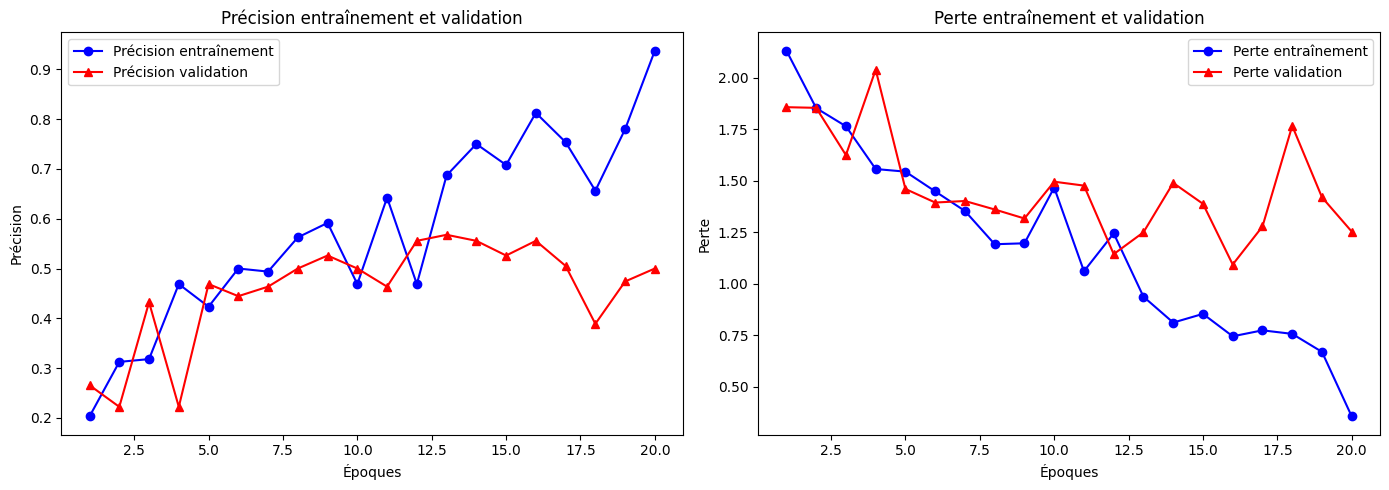

In [52]:

# Récupérer les données de l'historique
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


# Tracer la courbe de précision
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Précision entraînement')  # 'bo-' : bleu avec des points et lignes
plt.plot(epochs, val_acc, 'r^-', label='Précision validation')  # 'r^-' : rouge avec des triangles et lignes
plt.title('Précision entraînement et validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

# Tracer la courbe de perte
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Perte entraînement')  # 'bo-' : bleu avec des points et lignes
plt.plot(epochs, val_loss, 'r^-', label='Perte validation')  # 'r^-' : rouge avec des triangles et lignes
plt.title('Perte entraînement et validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

- **Enregistrement du modèle**

In [138]:
from keras.models import load_model

# Chemin où vous voulez sauvegarder votre modèle
save_path = "C:/Users/521169/Documents/Openclassrooms/Projet 6/Jeu de donnée/Dataset+projet+prétraitement+textes+images (1)/Flipkart/Images_model.keras"
# 'model' est votre modèle  entraîné
model.save(save_path)

print(f"Modèle sauvegardé à l'emplacement : {save_path}")

Modèle sauvegardé à l'emplacement : C:/Users/521169/Documents/Openclassrooms/Projet 6/Jeu de donnée/Dataset+projet+prétraitement+textes+images (1)/Flipkart/Images_model.keras


In [139]:
from keras.utils import load_img, img_to_array

# Charger le modèle sauvegardé
model = load_model(r"C:/Users/521169/Documents/Openclassrooms/Projet 6/Jeu de donnée/Dataset+projet+prétraitement+textes+images (1)/Flipkart/Images_model.keras")
#  Sélectionner aléatoirement 10 images 
dfs = df_final.sample(n=10, random_state=42)

In [140]:
# Générateur pour les données de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dfs,
    directory=img_path,
    x_col='Folder_Image',
    y_col='CATEGORIES2',
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    shuffle=False  # Ne pas mélanger les données de test
)

# Faire des prédictions
predictions = model.predict(test_generator)

Found 10 validated image filenames belonging to 5 classes.


C:\Users\521169\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [142]:
dfs.head()

,Folder_Image,CATEGORIES2
369,597a9549a3e397d52dca62ee47b1f60a.jpg,Home Furnishing
706,a1fd886094826c3f25c6ffb380073974.jpg,Kitchen & Dining
502,7680c6bf930669dc0646e3315187dc8c.jpg,Beauty and Personal Care
405,62c35de4df27437d3597963fac55a8b6.jpg,Watches
35,08452abdadb3db1e686b94a9c52fc7b6.jpg,Watches


### 4.3 Prédiction du modèle initiale

In [143]:
# Convertir les prédictions en indices des classes (catégorie avec softmax)
predicted_indices = predictions.argmax(axis=1)
# Convertir les indices en noms de classes
predicted_classes = [dfs['CATEGORIES2'].to_list()[idx] for idx in predicted_indices]

# Ajouter les prédictions au DataFrame
dfs['predictions'] = predicted_classes
dfs

,Folder_Image,CATEGORIES2,predictions
369,597a9549a3e397d52dca62ee47b1f60a.jpg,Home Furnishing,Watches
706,a1fd886094826c3f25c6ffb380073974.jpg,Kitchen & Dining,Baby Care
502,7680c6bf930669dc0646e3315187dc8c.jpg,Beauty and Personal Care,Kitchen & Dining
405,62c35de4df27437d3597963fac55a8b6.jpg,Watches,Watches
35,08452abdadb3db1e686b94a9c52fc7b6.jpg,Watches,Watches
459,6eabdbbbffdfae86c3c5177ba0f96ea7.jpg,Baby Care,Watches
215,35a68b44bef47a809314493d28535b9d.jpg,Watches,Watches
442,6acca991d2353781779b866e4f96edd9.jpg,Home Furnishing,Watches
124,1dbe1f3ba28460dffef4a1d664549621.jpg,Beauty and Personal Care,Watches
731,a79117ea49a0533f641facdb4c99f502.jpg,Home Furnishing,Home Furnishing


####

# 5. Approche nouvelle par Dataset sans data augmentation

In [109]:
from tensorflow.keras.applications import VGG16
# Initialisation de la base convolutionnelle du modèle VGG16 préentraîné.
# weights='imagenet' signifie que le modèle est préentraîné sur l'ensemble de données ImageNet, qui contient des millions d'images annotées.
# include_top=False signifie que les couches de classification dense (top layers) ne sont pas incluses,
# ce qui permet d'utiliser le modèle comme un extracteur de caractéristiques sans la dernière couche de classification.
# input_shape=(224, 224, 3) définit la taille des images d'entrée attendues par le modèle (150x150 pixels avec 3 canaux pour RGB).
conv_base = VGG16(weights='imagenet',
                  include_top=False, # la derniere couche de prédiction ne sera pas utiliser
                  input_shape=(224, 224, 3))

In [111]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 1. Extraction Rapide des Caractéristiques sans Augmentation des Données
Cette technique utilise les couches convolutives d'un modèle préentraîné pour extraire des caractéristiques des images sans augmentation des données.

#### Étapes :
- Charger le modèle préentraîné sans la couche de classification finale.
- Geler les poids des couches convolutives.
- Ajouter des couches de classification.
- Compiler et entraîner le modèle avec les nouvelles données.

### °° Technique sans data augmentation

In [112]:
batch_size=20

def extract_features(df_final, sample_count):
  features = np.zeros(shape=(sample_count,7, 7, 512)) 
  labels = np.zeros((sample_count, 7))  
  generator = data_gen.flow_from_dataframe(df_final,
                                          img_path,
                                          x_col='Folder_Image',
                                          y_col='CATEGORIES2',
                                           target_size=(224, 224),
                                           batch_size=batch_size,
                                           class_mode='categorical')
  for idx, (inputs_batch, labels_batch) in enumerate(generator):
    features_batch = conv_base.predict(inputs_batch) # permet de d'extraire ou prédire les caractéristiques de l'image d'entrée
    features[idx * batch_size: (idx + 1) * batch_size] = features_batch
    labels[idx * batch_size: (idx + 1) * batch_size] = labels_batch
    if (idx + 1) * batch_size >= sample_count:
      break

  return features, labels

In [113]:
data_gen = ImageDataGenerator(rescale=1.0/255) # recaler ou normaliser afin de passer de 0 à 255 à 0 et 1 pour entrainer un reseau de neurone

In [114]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Initialiser les générateurs de données pour extraire les caractéristiques
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [115]:
df_final.head()

,Folder_Image,CATEGORIES2
0,009099b1f6e1e8f893ec29a7023153c4.jpg,Watches
1,0096e89cc25a8b96fb9808716406fe94.jpg,Kitchen & Dining
3,00cbbc837d340fa163d11e169fbdb952.jpg,Home Furnishing
5,00d84a518e0550612fcfcba3b02b6255.jpg,Beauty and Personal Care
7,00e966a5049a262cfc72e6bbf68b80e7.jpg,Computers


In [116]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
df_train, df_test = train_test_split(df_final, test_size=0.2, random_state=42)

# Afficher la taille des ensembles d'entraînement et de test
print(f"Taille de l'ensemble d'entraînement : {df_train.shape[0]}")
print(f"Taille de l'ensemble de test : {df_test.shape[0]}")

Taille de l'ensemble d'entraînement : 840
Taille de l'ensemble de test : 210


In [117]:
train_features, train_labels = extract_features(df_train, 840)

Found 840 validated image filenames belonging to 7 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


C:\Users\521169\AppData\Roaming\Python\Python311\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [118]:
val_features, val_labels = extract_features(df_test, 210)
test_features, test_labels = val_features, val_labels

Found 210 validated image filenames belonging to 7 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [119]:
# Aplatir les caractéristiques train
train_features = train_features.reshape((840, 7 * 7 * 512))
# Aplatir les caractéristiques validation
val_features = val_features.reshape((210, 7 * 7 * 512))

# Construire et compiler le modèle de classification
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))# ajout de la couche dropout pour eviter le surapprentissage
model.add(layers.Dense(7, activation='softmax'))
model.summary()

C:\Users\521169\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,424,583 (24.51 MB)

 Trainable params: 6,424,583 (24.51 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(train_features, train_labels,
                    epochs=15,
                    batch_size=20,
                    validation_data=(val_features, val_labels))

Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.2858 - loss: 1.8774 - val_accuracy: 0.6619 - val_loss: 1.2144
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5904 - loss: 1.1888 - val_accuracy: 0.6810 - val_loss: 0.9455
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6867 - loss: 0.9183 - val_accuracy: 0.7476 - val_loss: 0.7983
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7605 - loss: 0.7627 - val_accuracy: 0.7476 - val_loss: 0.7285
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7966 - loss: 0.6228 - val_accuracy: 0.7714 - val_loss: 0.6823
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8418 - loss: 0.5059 - val_accuracy: 0.7810 - val_loss: 0.6578
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8771 - loss: 0.4673 - val_accuracy: 0.7952 - val_loss: 0.6121
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8767 - loss: 0.4009 - val_accuracy: 0.8000 - v

In [121]:
val_features = val_features.reshape((210, 7 * 7 * 512))

# Évaluation du modèle sur l'ensemble de test
test_loss, test_acc = model.evaluate(val_features, val_labels)
print(f'Test accuracy: {test_acc:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8213 - loss: 0.4861
Test accuracy: 0.82


### 5.2 Performance du modèle

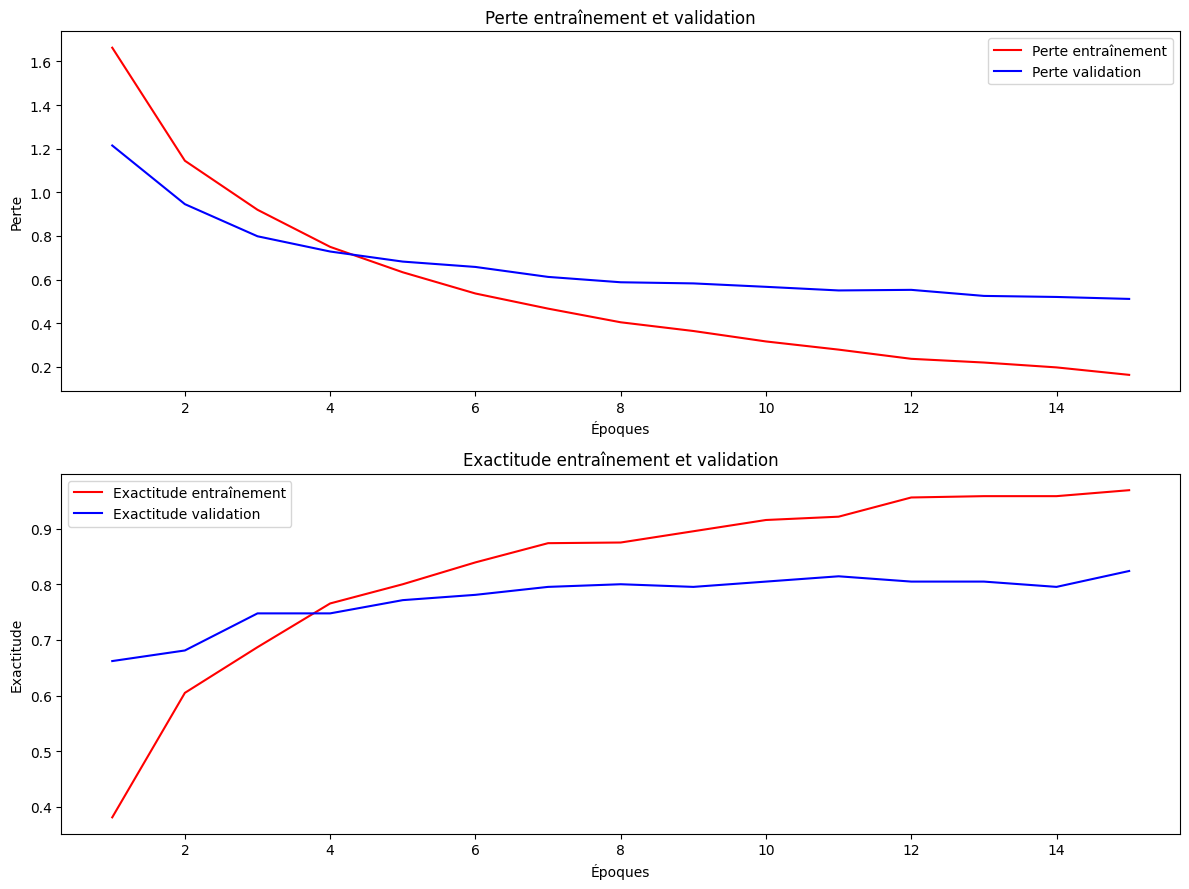

In [122]:
# Tracer les courbes d'apprentissage pour l'entraînement et la validation
history_dict = history.history

# Récupérer les valeurs de perte et d'exactitude pour chaque époque
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

import matplotlib.pyplot as plt

# Tracer la courbe de la perte d'entraînement et de validation
plt.figure(figsize=(12, 9))

plt.subplot(2, 1, 1)
plt.plot(epochs, loss_values, 'r-', label='Perte entraînement')  # Rouge pour la perte d'entraînement
plt.plot(epochs, val_loss_values, 'b-', label='Perte validation')  # Bleu pour la perte de validation
plt.title('Perte entraînement et validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

# Tracer la courbe de l'exactitude d'entraînement et de validation
plt.subplot(2, 1, 2)
plt.plot(epochs, acc_values, 'r-', label='Exactitude entraînement')  # Rouge pour l'exactitude d'entraînement
plt.plot(epochs, val_acc_values, 'b-', label='Exactitude validation')  # Bleu pour l'exactitude de validation
plt.title('Exactitude entraînement et validation')
plt.xlabel('Époques')
plt.ylabel('Exactitude')
plt.legend()

plt.tight_layout()
plt.show()

#

# 6. Approche nouvelle par Dataset avec data augmentation

Cette technique utilise les couches convolutives d'un modèle préentraîné pour extraire des caractéristiques des images tout en utilisant l'augmentation des données.

### Étapes :
- Charger le modèle préentraîné sans la couche de classification finale.
- Geler les poids des couches convolutives.
- Configurer l'augmentation des données (rotation, retournement, zoom, etc.).
- Ajouter des couches de classification.
- Compiler et entraîner le modèle avec les données augmentées.

### 6.1 Modèle

In [123]:
# Geler les poids des couches convolutives pour éviter de les entraîner à nouveau
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

In [69]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,139,271 (80.64 MB)

 Trainable params: 6,424,583 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [124]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])  

In [125]:
# Initialiser les générateurs de données pour l'augmentation des données
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [126]:
# Initialiser les générateurs de données pour l'augmentation des données
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=img_path,
    x_col='Folder_Image',
    y_col='CATEGORIES2',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=img_path,
    x_col='Folder_Image',
    y_col='CATEGORIES2',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [127]:
# Entraîner le modèle
history = model.fit(train_generator,
                    epochs=15,
                    batch_size=100,
                    validation_data=validation_generator)  # Entraîner le modèle avec les caractéristiques extraites

C:\Users\521169\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
 2/27 ━━━━━━━━━━━━━━━━━━━━ 2:41 6s/step - accuracy: 0.2812 - loss: 2.0122 

C:\Users\521169\AppData\Roaming\Python\Python311\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 205s 7s/step - accuracy: 0.2976 - loss: 1.8408 - val_accuracy: 0.5333 - val_loss: 1.3236
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 199s 7s/step - accuracy: 0.5494 - loss: 1.3969 - val_accuracy: 0.6571 - val_loss: 1.0711
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 187s 7s/step - accuracy: 0.6376 - loss: 1.1730 - val_accuracy: 0.6762 - val_loss: 0.9150
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 189s 7s/step - accuracy: 0.7009 - loss: 1.0397 - val_accuracy: 0.7095 - val_loss: 0.8296
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 186s 7s/step - accuracy: 0.6999 - loss: 0.9250 - val_accuracy: 0.7238 - val_loss: 0.7659
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 182s 7s/step - accuracy: 0.7322 - loss: 0.8923 - val_accuracy: 0.7381 - val_loss: 0.7617
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 190s 7s/step - accuracy: 0.7299 - loss: 0.8555 - val_accuracy: 0.7619 - val_loss: 0.7045
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 209s 8s/step - accuracy: 0.7545 - loss: 0.8034 - val_accuracy: 0.7476 - val_loss: 0.

### 6.2 Performance du Modèle

In [ ]:
# Évaluation du modèle sur l'ensemble de test
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test accuracy: {test_acc:.2f}')

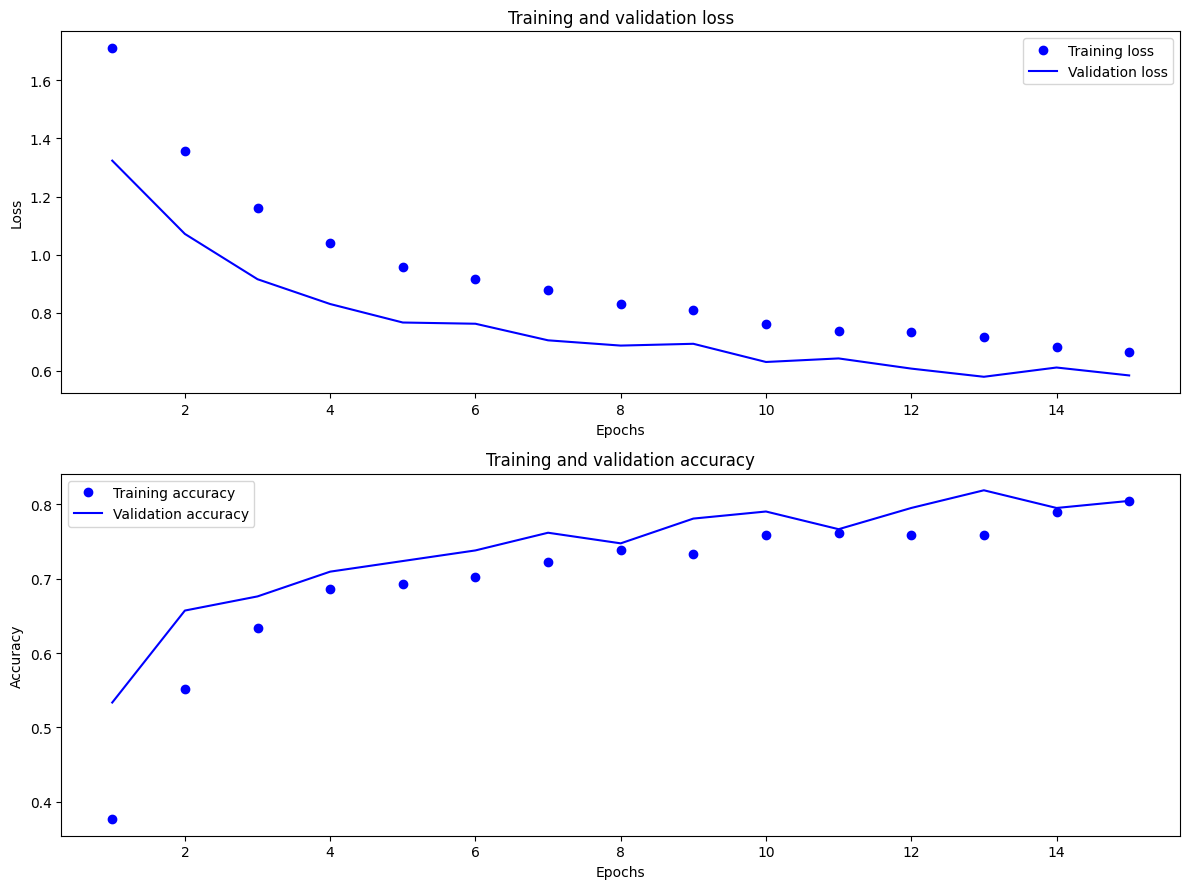

In [128]:
# Tracer les courbes d'apprentissage pour l'entraînement et la validation
history_dict = history.history

# Récupérer les valeurs de perte et d'exactitude pour chaque époque
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

# Tracer la courbe de la perte d'entraînement et de validation
plt.figure(figsize=(12, 9))

plt.subplot(2, 1, 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Tracer la courbe de l'exactitude d'entraînement et de validation
plt.subplot(2, 1, 2)
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#